In [ ]:
import chainer.serializers
chainer.serializers.load_npz('mnist_generator',generator)
chainer.serializers.load_npz('mnist_discriminator',discriminator)
###### you could directly use the generator and discriminator after loading

In [1]:
import argparse
import numpy as np
from chainer import datasets, cuda, serializers, Variable
from chainer import optimizers as O
from chainer import functions as F
from models import Generator, Discriminator


def rnd_categorical(n, n_categorical):
    indices = np.random.randint(n_categorical, size=n)
    one_hot = np.zeros((n, n_categorical))
    one_hot[np.arange(n), indices] = 1
    return one_hot, indices


def rnd_continuous(n, n_continuous, mu=0, std=1):
    return np.random.normal(mu, std, size=(n, n_continuous))


n_z = 62
n_categorical = 10
n_continuous = 2
max_epochs = 10000
batch_size = 1000


# Prepare the training data
train, _ = datasets.get_mnist(withlabel=False, ndim=2)
train_size = train[0:10000].shape[0]
im_shape = train.shape[1:]



In [6]:
# # Prepare the models
# generator = Generator(n_z + n_categorical + n_continuous, im_shape)
# generator_optimizer = O.Adam(alpha=1e-3, beta1=0.5)
# generator_optimizer.setup(generator)

# discriminator = Discriminator(im_shape, n_categorical, n_continuous)
# discriminator_optimizer = O.Adam(alpha=2e-4, beta1=0.5)
# discriminator_optimizer.setup(discriminator)

# xp = np

for epoch in range(max_epochs):
    generator_epoch_loss = np.float32(0)
    discriminator_epoch_loss = np.float32(0)

    for i in range(0, train_size, batch_size):
        # Sample noise z
        zs = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

        # Sample a category encoded as a one-hot vector to hopefully learn a digit
        c_categorical, categories = rnd_categorical(batch_size, n_categorical)
        c_categorical = xp.asarray(c_categorical, dtype=xp.float32)
        categories = xp.asarray(categories, dtype=xp.int32)

        # Sample continuous codes to learn rotation, thickness, etc.
        c_continuous = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)

        zc = xp.concatenate((zs, c_categorical, c_continuous), axis=1)

        # Forward
        x_fake = generator(zc)
        y_fake, mi = discriminator(x_fake)

        x_real = xp.zeros((batch_size, 28,28), dtype=xp.float32)
        for xi in range(len(x_real)):
            x_real[xi] = xp.array(train[np.random.randint(train_size)])
        
        x_real = xp.expand_dims(x_real, 1)
        y_real, _ = discriminator(x_real)

        # Losses
        generator_loss = F.softmax_cross_entropy(y_fake, xp.ones(batch_size, dtype=xp.int32))
        discriminator_loss = F.softmax_cross_entropy(y_fake, xp.zeros(batch_size, dtype=xp.int32))
        discriminator_loss += F.softmax_cross_entropy(y_real, xp.ones(batch_size, dtype=xp.int32))

        # Mutual Information loss
        mi_categorical, mi_continuous_mean = F.split_axis(mi, [n_categorical], 1)

        # Categorical loss
        categorical_loss = F.softmax_cross_entropy(mi_categorical, categories, use_cudnn=False)

        # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
        mi_continuous_ln_var = xp.empty_like(mi_continuous_mean.data, dtype=xp.float32)
        mi_continuous_ln_var.fill(1)
        # mi_continuous_ln_var.fill(1e-6)
        continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
        continuous_loss /= batch_size

        generator_loss += categorical_loss
        generator_loss += continuous_loss

        # Backprop
        generator_optimizer.zero_grads()
        generator_loss.backward()
        generator_optimizer.update()

        discriminator_optimizer.zero_grads()
        discriminator_loss.backward()
        discriminator_optimizer.update()

        generator_epoch_loss += generator_loss.data
        discriminator_epoch_loss += discriminator_loss.data

    generator_avg_loss = generator_epoch_loss / train_size
    discriminator_avg_loss = discriminator_epoch_loss / train_size

    print('Epoch {} Loss Generator: {} Loss Discriminator: {}'
          .format(epoch + 1, generator_avg_loss, discriminator_avg_loss))


print('Finished training')

Epoch 1 Loss Generator: 0.00443721694946 Loss Discriminator: 0.000956567001343
Epoch 2 Loss Generator: 0.00446781234741 Loss Discriminator: 0.00100511264801
Epoch 3 Loss Generator: 0.00447384986877 Loss Discriminator: 0.00101970214844
Epoch 4 Loss Generator: 0.0044820514679 Loss Discriminator: 0.000998029899597
Epoch 5 Loss Generator: 0.00451375274658 Loss Discriminator: 0.00103998994827
Epoch 6 Loss Generator: 0.00447784805298 Loss Discriminator: 0.000988598537445
Epoch 7 Loss Generator: 0.00448001289368 Loss Discriminator: 0.000989145183563
Epoch 8 Loss Generator: 0.00449136619568 Loss Discriminator: 0.000969076347351
Epoch 9 Loss Generator: 0.00450287208557 Loss Discriminator: 0.000998695850372
Epoch 10 Loss Generator: 0.00447957382202 Loss Discriminator: 0.000971669578552
Epoch 11 Loss Generator: 0.0044866065979 Loss Discriminator: 0.000951881504059
Epoch 12 Loss Generator: 0.00449896087646 Loss Discriminator: 0.000974506664276
Epoch 13 Loss Generator: 0.00452025527954 Loss Discrim

KeyboardInterrupt: 

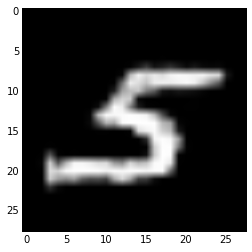

In [7]:
# Quick check the training result
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(generator(zc).data[0].reshape(28,28),'gray')

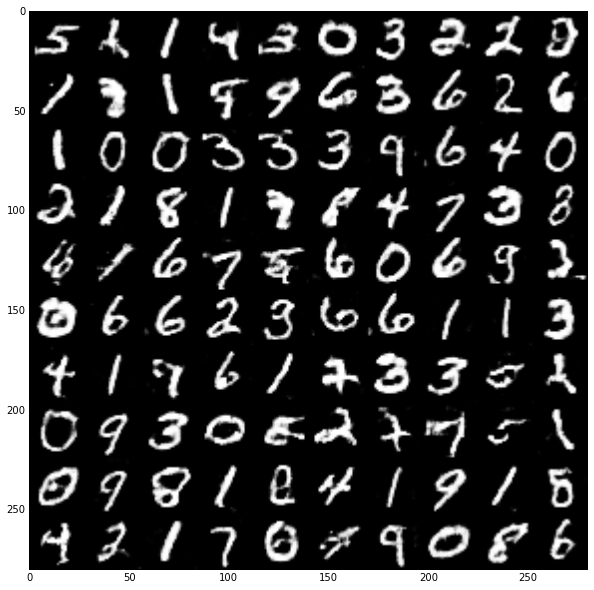

In [8]:
# Check the training result
import random
from matplotlib import pyplot as plt
%matplotlib inline
n = 10  # figure with 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    for i, yi in enumerate(grid_x):
        z_sample = zc
        z_sample=z_sample.astype(np.float32)
        x_decoded = generator(z_sample).data[i+j*10]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

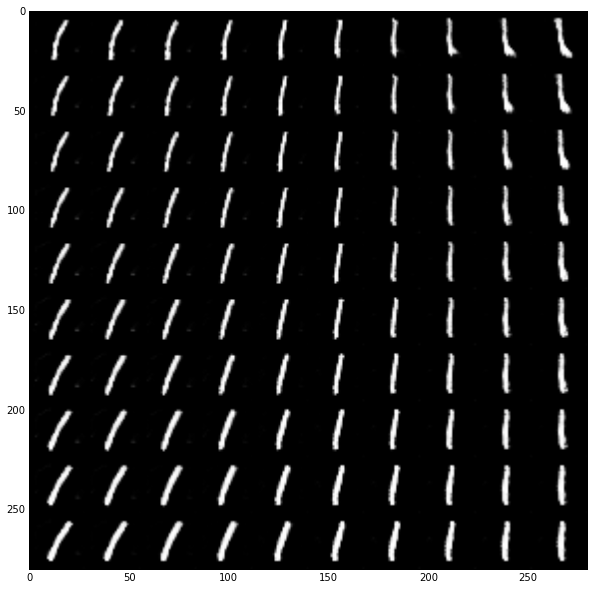

In [9]:

n = 10  # figure with 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)
c_categorical2 = np.zeros((batch_size,n_categorical), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-1)
    c_categorical2[ii,roll]=1
c_categorical2[0,:]=0
c_categorical2[0,0]=1

c_continuous2 = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)
#c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[yi, xi]], dtype=np.float32)

        zc2 = xp.concatenate((zs2, c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [10]:
# Save the model
import chainer.serializers
chainer.serializers.save_npz('mnist_generator',generator)
chainer.serializers.save_npz('mnist_discriminator',discriminator)